In [36]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using Plots

  Activating environment at `~/CMU/16-745 Optimal Control/HEXROTOR_MODELING/Project.toml`


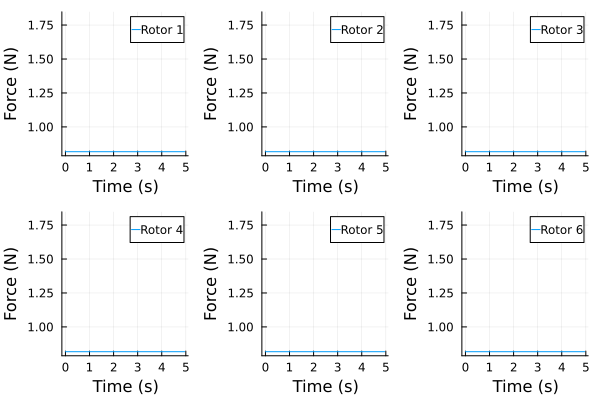

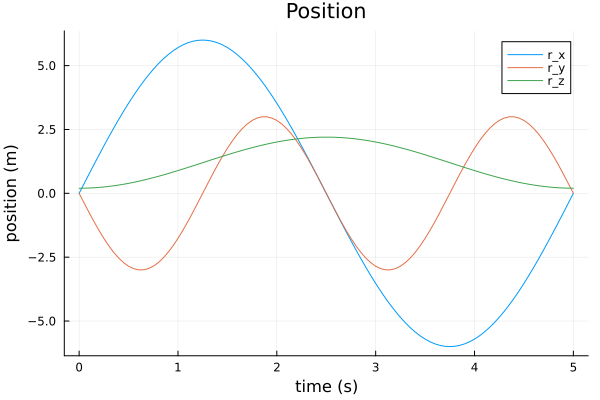

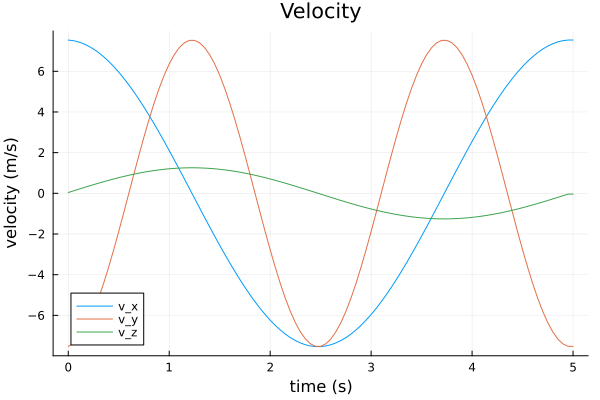

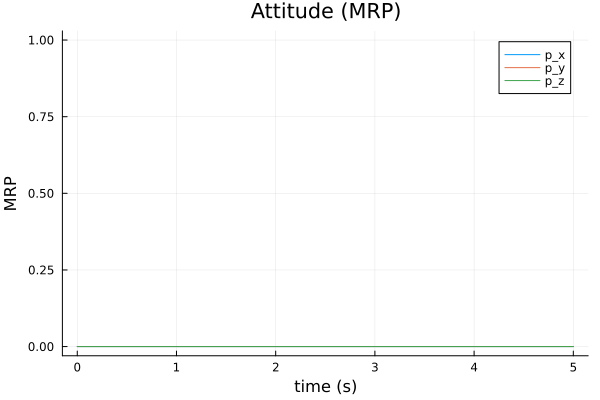

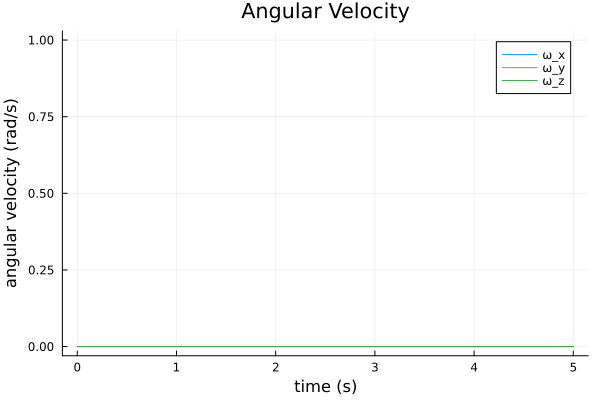

In [59]:
###### practice with reference trajectory from homework 3 *** kind of the figure 8 thing

function create_reference(params, N, dt)
    # create reference trajectory for quadrotor 
    mass= params.mass

    R = 6
    Xref = [ [R*cos(t);R*cos(t)*sin(t);1.2 + sin(t);zeros(9)] 
        for t = range(-pi/2,3*pi/2, length = N)]
    for i = 1:(N-1)
        Xref[i][4:6] = (Xref[i+1][1:3] - Xref[i][1:3])/dt
    end
    Xref[N][4:6] = Xref[N-1][4:6]
    Uref = [(9.81*mass/6)*ones(6) for i = 1:(N-1)]
    return Xref, Uref
end

# parameters
dt = 0.05 
tf = 5 
t_vec = 0:dt:tf 
N = length(t_vec)
mass= 5

params= [mass]

# Generate hover trajectory for hexrotor
Xref, Uref = create_reference(N, dt)
Um = hcat(Uref...)
Xm = hcat(Xref...)


# Plot Uref against time for each rotor
display(plot(t_vec[1:end-1], Um', layout= 6, xlabel="Time (s)", ylabel="Force (N)", 
    label=["Rotor 1" "Rotor 2" "Rotor 3" "Rotor 4" "Rotor 5" "Rotor 6"]))

# plot Xref against time
display(plot(t_vec, Xm[1:3,:]', xlabel = "time (s)", ylabel = "position (m)",
title = "Position", label = ["r_x" "r_y" "r_z"]))
display(plot(t_vec, Xm[4:6,:]', xlabel = "time (s)", ylabel = "velocity (m/s)",
title = "Velocity", label = ["v_x" "v_y" "v_z"]))
display(plot(t_vec, Xm[7:9,:]', xlabel = "time (s)", ylabel = "MRP",
title = "Attitude (MRP)", label = ["p_x" "p_y" "p_z"]))
display(plot(t_vec, Xm[10:12,:]', xlabel = "time (s)", ylabel = "angular velocity (rad/s)",
title = "Angular Velocity", label = ["ω_x" "ω_y" "ω_z"]))



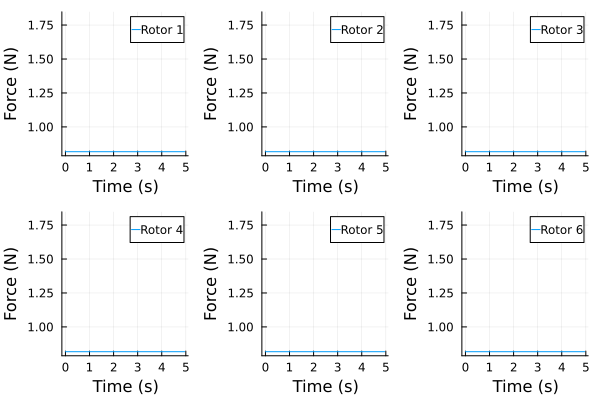

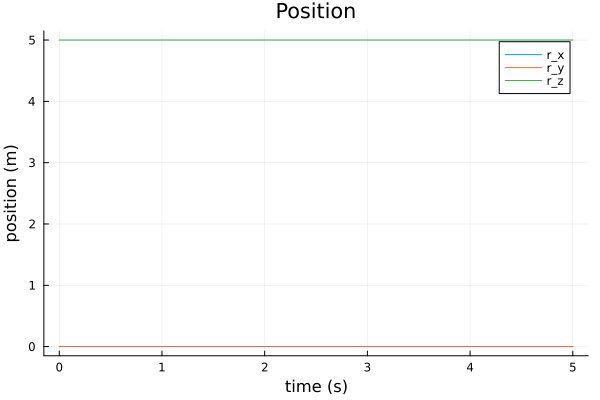

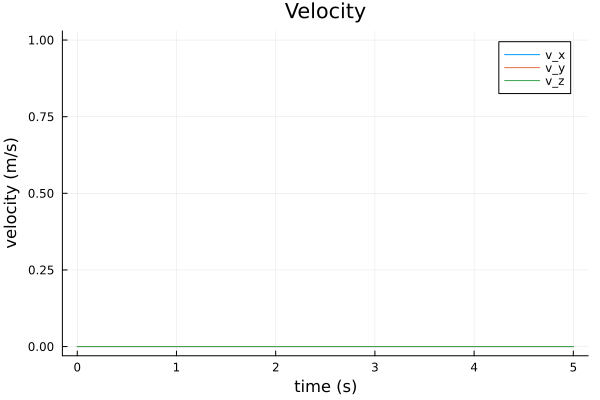

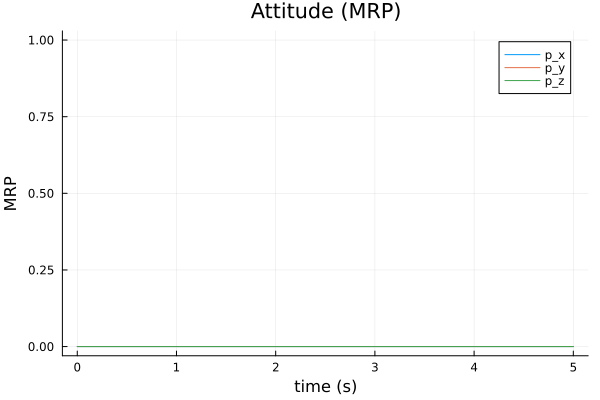

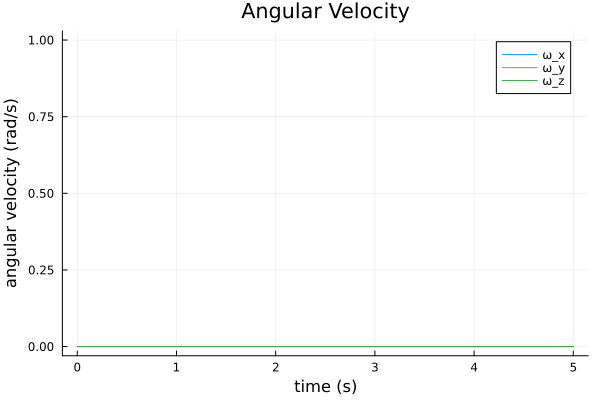

In [58]:
function create_ref_hover(N, dt)
    # create a hover reference (with no pitch) for whole time period

    # hover altitude
    desired_altitude= 5.0

    # hover state
    hover_position = [0.0; 0.0; desired_altitude]  # Hover at (0, 0, 5)
    hover_velocity = [0.0; 0.0; 0.0]  # no velocity
    hover_attitude = [0.0; 0.0; 0.0]  # No roll, pitch, yaw
    hover_angvelocity= [0.0; 0.0; 0.0] # no angular velocity
    
    Xref= [zeros(12) for i = 1:N]
    for i= 1:N
        Xref[i]= [hover_position; hover_velocity; hover_attitude; hover_angvelocity]
    end

    Uref = [(9.81*0.5/6)*ones(6) for i = 1:(N-1)]
    return Xref, Uref
end



# parameters
dt = 0.05 
tf = 5 
t_vec = 0:dt:tf 
N = length(t_vec)

# Generate hover trajectory for hexrotor
Xref, Uref = create_ref_hover(N, dt)
Um = hcat(Uref...)
Xm = hcat(Xref...)


# Plot Uref against time for each rotor
display(plot(t_vec[1:end-1], Um', layout= 6, xlabel="Time (s)", ylabel="Force (N)", 
    label=["Rotor 1" "Rotor 2" "Rotor 3" "Rotor 4" "Rotor 5" "Rotor 6"]))
# plot Xref against time
display(plot(t_vec, Xm[1:3,:]', xlabel = "time (s)", ylabel = "position (m)",
title = "Position", label = ["r_x" "r_y" "r_z"]))
display(plot(t_vec, Xm[4:6,:]', xlabel = "time (s)", ylabel = "velocity (m/s)",
title = "Velocity", label = ["v_x" "v_y" "v_z"]))
display(plot(t_vec, Xm[7:9,:]', xlabel = "time (s)", ylabel = "MRP",
title = "Attitude (MRP)", label = ["p_x" "p_y" "p_z"]))
display(plot(t_vec, Xm[10:12,:]', xlabel = "time (s)", ylabel = "angular velocity (rad/s)",
title = "Angular Velocity", label = ["ω_x" "ω_y" "ω_z"]))


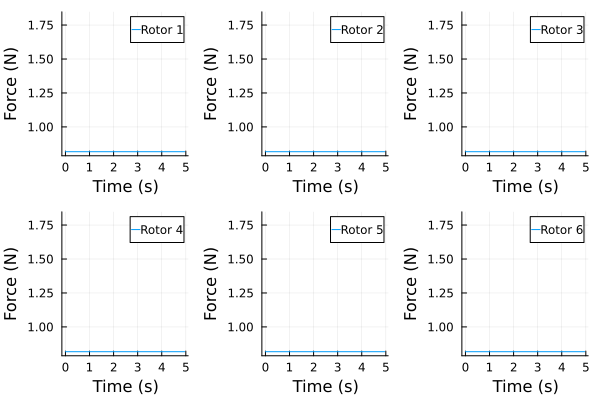

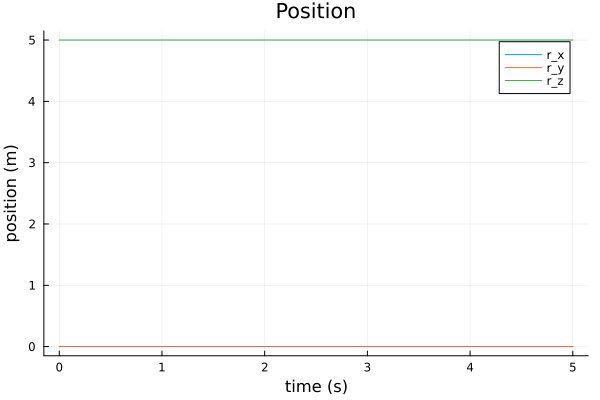

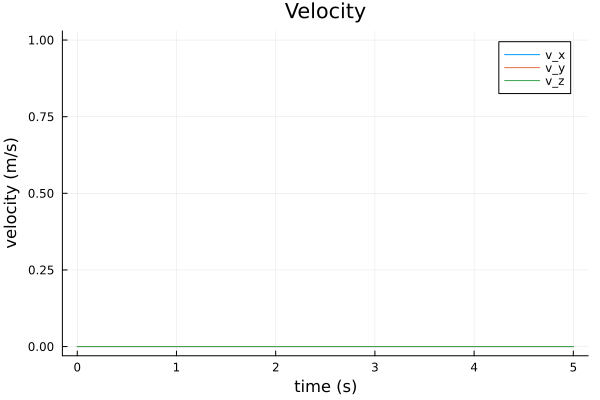

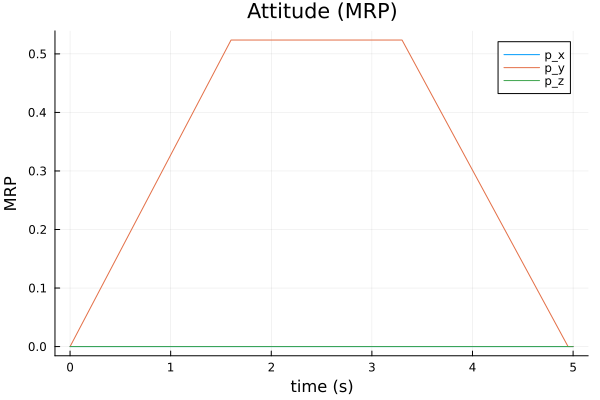

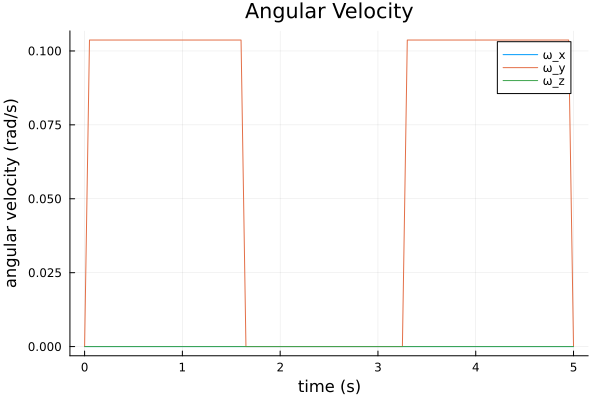

101

In [78]:
function create_ref_angle_hover(N, dt, desired_pitch_degrees, desired_altitude)
    # create a hover trajectory at a desired pitch (single angle)
    # start: stable hover (0 degrees pitch)
    # middle: pitch to a certain angle
    # end: stable hover (0 degrees pitch)

    #desired_altitude= 5.0
    # convert to radians
    desired_pitch_radians= desired_pitch_degrees * π / 180

    mass= 0.5
     
    # Start with a stable hover at 0 degrees pitch
    Xref= [zeros(12) for i = 1:N]
    for i= 1:N
        # start
        hover_position = [0.0, 0.0, desired_altitude]  # Hover at (0, 0, 5)
        hover_velocity = [0.0, 0.0, 0.0]  # no velocity at hover start
        hover_attitude= [0.0, 0.0, 0.0] # no roll, pitch, yaw
        hover_angvelocity= [0.0, 0.0, 0.0] # no angular velocity
        Xref[i]= [hover_position; hover_velocity; hover_attitude; hover_angvelocity]
    end

    # Calculate desired angular velocity (assuming constant angular acceleration)
    desired_angular_velocity = desired_pitch_radians / (N * dt)

    # Transition to the desired pitch angle
    transition_time = div(N, 3) # divide timesteps in to thirds
    for i in 2:transition_time
        Xref[i][8] = desired_pitch_radians / (transition_time - 1) * (i - 1)
        Xref[i][11] = desired_angular_velocity  # Angular velocity around pitch axis
    end

    # Maintain the hover at the desired pitch angle
    for i in transition_time+1: 2*transition_time
        Xref[i][8] = desired_pitch_radians
        Xref[i][11] = 0  # no angular velocity once it reaches desired pitch
    end

    # Transition back to a stable hover at 0 degrees pitch
    for i in 2*transition_time+1:N-1
        Xref[i][8] = desired_pitch_radians - desired_pitch_radians / transition_time * (i - (2*transition_time+1))
        Xref[i][11] = desired_angular_velocity
    end

    Uref = [(9.81*mass/6)*ones(6) for i = 1:(N-1)]

    return Xref, Uref

end

# parameters
dt = 0.05 
tf = 5 
t_vec = 0:dt:tf 
N = length(t_vec)

desired_pitch= 30
desired_altitude= 5

# Generate hover trajectory for hexrotor
Xref, Uref = create_ref_angle_hover(N, dt, desired_pitch, desired_altitude)
Um = hcat(Uref...)
Xm = hcat(Xref...)


# Plot Uref against time for each rotor
display(plot(t_vec[1:end-1], Um', layout= 6, xlabel="Time (s)", ylabel="Force (N)", 
    label=["Rotor 1" "Rotor 2" "Rotor 3" "Rotor 4" "Rotor 5" "Rotor 6"]))
# plot Xref against time
display(plot(t_vec, Xm[1:3,:]', xlabel = "time (s)", ylabel = "position (m)",
title = "Position", label = ["r_x" "r_y" "r_z"]))
display(plot(t_vec, Xm[4:6,:]', xlabel = "time (s)", ylabel = "velocity (m/s)",
title = "Velocity", label = ["v_x" "v_y" "v_z"]))
display(plot(t_vec, Xm[7:9,:]', xlabel = "time (s)", ylabel = "MRP",
title = "Attitude (MRP)", label = ["p_x" "p_y" "p_z"]))
display(plot(t_vec, Xm[10:12,:]', xlabel = "time (s)", ylabel = "angular velocity (rad/s)",
title = "Angular Velocity", label = ["ω_x" "ω_y" "ω_z"]))


In [42]:
function create_ref_multangle_hover(N, dt)
    # create a hover trajectory at multiple angles (pitch to certain angle and then yaw 360?, then recover to 0 degrees pitch )
    # start: stable hover (0 degrees pitch)
    # middle: cylce through mulitple pitch angles
    # end: stable hover (0 degrees pitch)

    # pitch to certain angle, then rotate 180 (yaw)

    # pitch to a certain angle then roll?


    # 180 singularity?


end

create_ref_multangle_hover (generic function with 1 method)

In [43]:
function create_ref_fig8(N, dt)
    # create a figure 8 reference tracking
    # no pitch angle
    # end at hover




end

create_ref_fig8 (generic function with 1 method)

In [44]:
# recovery maneuver?
# start at some craxy angle and linearly interpolate to recover to stable hover by end of trajectory

In [ ]:
# figure 8 with banking 
# 

In [ ]:
# up and down like a roller coaster with stable hover and with pitch
# go forward and backwards

In [ ]:
#### figure 8 without tilting the drone (because it is fully actuated)

# attitude (in world frame) all zero
# angular velocity is zero





In [ ]:
function calculate_hover_thrust(mass::Float64)
    # Acceleration due to gravity (m/s^2)
    g = 9.81
    
    # Calculate weight (force exerted by gravity)
    weight = mass * g
    
    # The thrust required for hover is equal to the weight of the drone
    hover_thrust = weight
    
    return hover_thrust
end

# Example usage:
mass = 1.0  # Mass of the drone in kilograms
hover_thrust = calculate_hover_thrust(mass)
println("Thrust required for hover: ", hover_thrust, " N")



function generate_reference_trajectory(t::Float64)
    # Define parameters for figure 8 trajectory
    amplitude = 1.0
    frequency = 1.0
    omega = 2 * π * frequency
    
    # Calculate desired position (x, y) for figure 8 trajectory
    x_ref = amplitude * sin(omega * t)
    y_ref = amplitude * sin(2 * omega * t)
    
    # Maintain constant altitude achieved during vertical ascent
    z_ref = 10.0
    
    # Construct reference trajectory vector
    X_ref = [x_ref, y_ref, z_ref]

    # we care about angle of drone, so set attitude and ang velocity to 0
    # we dont really care about velocity so dont set??
    
    return X_ref
end

function generate_reference_controls(X_ref::Vector{Float64})
    # For vertical ascent and descent, use thrust required for hover
    # For figure 8 trajectory, adjust thrust to maintain constant altitude
    
    # Calculate thrust required for hover
    hover_thrust = calculate_hover_thrust(mass)
    
    # For ascent, set thrust to hover thrust
    if X_ref[3] < desired_altitude
        U_ref = [0.0, 0.0, hover_thrust]
    # For figure 8 trajectory, adjust thrust to maintain constant altitude
    elseif t < t_figure_8_end
        # Adjust thrust to maintain constant altitude
        U_ref = [thrust_x, thrust_y, adjust_thrust_for_altitude(X_ref[3])]
    # For descent, gradually reduce thrust to hover thrust
    else
        U_ref = [0.0, 0.0, hover_thrust]
    end
    
    return U_ref
end

# Example usage:
desired_altitude = 10.0  # Desired altitude for vertical ascent
t_figure_8_end = 20.0    # Time when figure 8 trajectory ends
t = 0.0:0.1:30.0         # Time vector
X_ref = generate_reference_trajectory.(t)
U_ref = generate_reference_controls.(X_ref)



function adjust_thrust_for_altitude(current_altitude::Float64, desired_altitude::Float64, hover_thrust::Float64)
    # Proportional control gain (adjust as needed)
    Kp = 0.1
    
    # Calculate altitude error
    altitude_error = desired_altitude - current_altitude
    
    # Adjust thrust based on altitude error
    adjusted_thrust = hover_thrust + Kp * altitude_error
    
    return adjusted_thrust
end


In [ ]:

########## sample with starting on the ground, rising to hover, then going back to the ground
function generate_hover_trajectory(t::Float64, desired_altitude::Float64, hover_duration::Float64, hover_thrust::Float64)
    # Desired position is constant at desired altitude
    x_ref = 0.0
    y_ref = 0.0
    z_ref = desired_altitude
    
    # Desired velocities and accelerations are zero
    dx_dt_ref = 0.0
    dy_dt_ref = 0.0
    dz_dt_ref = 0.0
    
    # Desired attitude (roll, pitch, yaw) and angular velocities are zero
    phi_ref = 0.0
    theta_ref = 0.0
    psi_ref = 0.0
    p_ref = 0.0
    q_ref = 0.0
    r_ref = 0.0
    
    # Construct reference trajectory vector
    if t < hover_duration
        X_ref = [x_ref, y_ref, z_ref, dx_dt_ref, dy_dt_ref, dz_dt_ref, phi_ref, theta_ref, psi_ref, p_ref, q_ref, r_ref]
    else
        X_ref = [x_ref, y_ref, z_ref, dx_dt_ref, dy_dt_ref, dz_dt_ref, phi_ref, theta_ref, psi_ref, p_ref, q_ref, r_ref]
    end
    
    # Use hover thrust for hover
    U_ref = [hover_thrust, hover_thrust, hover_thrust, hover_thrust, hover_thrust, hover_thrust]
    
    return X_ref, U_ref
end


function generate_vertical_ascent_trajectory(t::Float64, desired_altitude::Float64, hover_thrust::Float64)
    # Desired position is constant at ground level
    x_ref = 0.0
    y_ref = 0.0
    z_ref = min(desired_altitude * t / ascent_duration, desired_altitude)  # Linear ascent
    
    # Desired velocities are zero
    dx_dt_ref = 0.0
    dy_dt_ref = 0.0
    dz_dt_ref = min(desired_altitude / ascent_duration, desired_altitude)  # Constant ascent rate
    
    # Desired attitude (roll, pitch, yaw) and angular velocities are zero
    phi_ref = 0.0
    theta_ref = 0.0
    psi_ref = 0.0
    p_ref = 0.0
    q_ref = 0.0
    r_ref = 0.0
    
    # Construct reference trajectory vector
    X_ref = [x_ref, y_ref, z_ref, dx_dt_ref, dy_dt_ref, dz_dt_ref, phi_ref, theta_ref, psi_ref, p_ref, q_ref, r_ref]
    
    # Use hover thrust for ascent
    U_ref = [hover_thrust, hover_thrust, hover_thrust, hover_thrust, hover_thrust, hover_thrust]
    
    return X_ref, U_ref
end

function generate_vertical_descent_trajectory(t::Float64, desired_altitude::Float64, hover_thrust::Float64)
    # Desired position is constant at desired altitude
    x_ref = 0.0
    y_ref = 0.0
    z_ref = desired_altitude - min(desired_altitude * t / descent_duration, desired_altitude)  # Linear descent
    
    # Desired velocities are zero
    dx_dt_ref = 0.0
    dy_dt_ref = 0.0
    dz_dt_ref = min(desired_altitude / descent_duration, desired_altitude)  # Constant descent rate
    
    # Desired attitude (roll, pitch, yaw) and angular velocities are zero
    phi_ref = 0.0
    theta_ref = 0.0
    psi_ref = 0.0
    p_ref = 0.0
    q_ref = 0.0
    r_ref = 0.0
    
    # Construct reference trajectory vector
    X_ref = [x_ref, y_ref, z_ref, dx_dt_ref, dy_dt_ref, dz_dt_ref, phi_ref, theta_ref, psi_ref, p_ref, q_ref, r_ref]
    
    # Use hover thrust for descent
    U_ref = [hover_thrust, hover_thrust, hover_thrust, hover_thrust, hover_thrust, hover_thrust]
    
    return X_ref, U_ref
end



function generate_trajectory(t::Float64, desired_altitude::Float64, hover_duration::Float64, ascent_duration::Float64, descent_duration::Float64, hover_thrust::Float64)
    if t < ascent_duration
        return generate_vertical_ascent_trajectory(t, desired_altitude, hover_thrust)
    elseif t < ascent_duration + hover_duration
        return generate_hover_trajectory(t - ascent_duration, desired_altitude, hover_duration, hover_thrust)
    else
        return generate_vertical_descent_trajectory(t - ascent_duration - hover_duration, desired_altitude, hover_thrust)
    end
end

# Example usage:
desired_altitude = 10.0    # Desired altitude for vertical ascent and descent
hover_duration = 5.0       # Duration of hover segment
ascent_duration = 10.0     # Duration of vertical ascent
descent_duration = 10.0    # Duration of vertical descent
hover



function generate_trajectory(total_duration::Float64, ascent_duration::Float64, hover_duration::Float64, descent_duration::Float64, desired_altitude::Float64, hover_thrust::Float64)
    # Initialize arrays to store reference states and controls
    X_ref = []
    U_ref = []
    
    # Time vector
    time_vector = collect(0:0.1:total_duration)  # Adjust the time step as needed
    
    # Generate vertical ascent trajectory
    for t in time_vector
        if t <= ascent_duration
            x_ref, y_ref, z_ref, dx_dt_ref, dy_dt_ref, dz_dt_ref, phi_ref, theta_ref, psi_ref, p_ref, q_ref, r_ref = generate_vertical_ascent_trajectory(t, desired_altitude, hover_thrust)
            push!(X_ref, [x_ref, y_ref, z_ref, dx_dt_ref, dy_dt_ref, dz_dt_ref, phi_ref, theta_ref, psi_ref, p_ref, q_ref, r_ref])
            push!(U_ref, [hover_thrust, hover_thrust, hover_thrust, hover_thrust, hover_thrust, hover_thrust])
        end
    end
    
    # Generate hover trajectory
    for t in time_vector
        if t > ascent_duration && t <= (ascent_duration + hover_duration)
            x_ref, y_ref, z_ref, dx_dt_ref, dy_dt_ref, dz_dt_ref, phi_ref, theta_ref, psi_ref, p_ref, q_ref, r_ref = generate_hover_trajectory(t, desired_altitude, hover_thrust)
            push!(X_ref, [x_ref, y_ref, z_ref, dx_dt_ref, dy_dt_ref, dz_dt_ref, phi_ref, theta_ref, psi_ref, p_ref, q_ref, r_ref])
            push!(U_ref, [hover_thrust, hover_thrust, hover_thrust, hover_thrust, hover_thrust, hover_thrust])
        end
    end
    
    # Generate vertical descent trajectory
    for t in time_vector
        if t > (ascent_duration + hover_duration) && t <= (total_duration)
            x_ref, y_ref, z_ref, dx_dt_ref, dy_dt_ref, dz_dt_ref, phi_ref, theta_ref, psi_ref, p_ref, q_ref, r_ref = generate_vertical_descent_trajectory(t - (ascent_duration + hover_duration), desired_altitude, hover_thrust)
            push!(X_ref, [x_ref, y_ref, z_ref, dx_dt_ref, dy_dt_ref, dz_dt_ref, phi_ref, theta_ref, psi_ref, p_ref, q_ref, r_ref])
            push!(U_ref, [hover_thrust, hover_thrust, hover_thrust, hover_thrust, hover_thrust, hover_thrust])
        end
    end
    
    return X_ref, U_ref
end


In [ ]:
function generate_vertical_ascent_trajectory(t::Float64, desired_altitude::Float64, hover_thrust::Float64, max_thrust_change_rate::Float64)

    
    # Linearly interpolate control thrust based on desired altitude
    hover_thrust= mass
    initial_thrust = 0.0
    final_thrust = hover_thrust
    current_thrust = initial_thrust + (final_thrust - initial_thrust) * min(t / ascent_duration, 1.0)
    
    
    # Use linearly interpolated thrust for ascent
    U_ref = [current_thrust, current_thrust, current_thrust, current_thrust, current_thrust, current_thrust]
    
    return X_ref, U_ref
end
